# Libraries

In [27]:
import numpy as np
import sympy as sp
import sympy.physics.quantum as sq
import sympy.physics.quantum.qubit as sqq
import sympy.physics.quantum.gate as sqg

import cvxpy as cp

import matplotlib.pyplot as plt
import networkx as nx

sp.init_printing(use_latex='mathjax')
from IPython.display import display

## Extending the braket library to include orthogonality

In [8]:
class onStruct:
    G = nx.Graph()

class onKet(sq.Ket,onStruct):
    def _eval_innerproduct(self,bra,**hints):
        #Check if the innerproduct is with yourself, then set 1
        if sq.Dagger(bra) == self:
            return sp.Integer(1)
        #Else, if the innerproduct is with a neighbor from the graph, set 0
        elif sq.Dagger(bra) in G[self]:
            return sp.Integer(0)
        #Else, do nothing; not enough information
    
    @classmethod
    def set_on_rel(cls,givenG):
        cls.G=givenG
    
    @classmethod
    def dual_class(self):
        return onBra

    
class onBra(sq.Bra,onStruct):
    @classmethod
    def dual_class(self):
        return onKet

In [9]:
class bKet(sq.Ket):
    
    #total number of kets (automatically increases as new instances are initialised)
    totalKets=0
    
    #this method automates the increase
    @classmethod
    def _eval_args(cls,args):
        #validate input type
        if not isinstance(args[0],int):
            raise ValueError("Integer expected in the argument, got: %r"%args[0])

        #if a ket |5> is initialised, the dimension is assumed to be 6 since we have |0>,|1>,...|5>
        if int(args[0])+1 > cls.totalKets:
            cls.totalKets=args[0]+1
        
        #pass control back to the base class
        return sq.Ket._eval_args(args) 
    
    #Could not find a way of using just one function; need to go through the two
    #based on a combination of the qubit implementation and the 
    def _represent_default_basis(s,**options):
        return s._represent_bKet(None,**options) #syntax taken from the Qubit library
    
    def _represent_bKet(s,basis,**options): #_represent_default_basis
        a=np.zeros(s.__class__.totalKets,dtype=int)
        a[s.label[0]]=1
        return sp.Matrix(a)
    
    @classmethod
    def set_dimension(cls,arg):
        cls.totalKets=arg
    
    def _eval_innerproduct(self,bra,**hints):
        #Check if the innerproduct is with yourself, then set 1
        if sq.Dagger(bra) == self:
            return sp.Integer(1)
        #Else, if the innerproduct is with a neighbor from the graph, set 0
        else:
            return sp.Integer(0)
        #Else, do nothing; not enough information
    

    @classmethod
    def dual_class(self):
        return bBra

    
class bBra(sq.Bra):
    # @classmethod
    # def _eval_args(cls,args):
    #     return args
    
    @classmethod
    def dual_class(cls):
        return bKet

### Debugging | representation example

In [473]:
class SzUpKet(sq.Ket):
    def _represent_SzUpKet(s,basis,**options):
        return sp.Matrix([1,0])
    
#     def _represent_SzOp(s,basis,**options):
#         return sp.Matrix([1,0])

class SzOp(sq.Operator):
    pass

sz = SzOp('Sz')
up = SzUpKet('up')
sq.represent(up,basis=SzUpKet) #,basis=sz)

Matrix([
[1],
[0]])

### Testing | Dimension increasing?

In [ ]:
# class bKet(sq.Ket):
    
#     #total number of kets (automatically increases as new instances are initialised)
#     totalKets=0
    
#     #this method automates the increase
#     @classmethod
#     def _eval_args(cls,args):
#         #validate input type
#         if not isinstance(args[0],int):
#             raise ValueError("Integer expected in the argument, got: %r"%args[0])

#         #if a ket |5> is initialised, the dimension is assumed to be 6 since we have |0>,|1>,...|5>
#         if int(args[0])+1 > cls.totalKets:
#             cls.totalKets=args[0]+1
        
#         #pass control back to the base class
#         return sq.Ket._eval_args(args) 
    
#     #Could not find a way of using just one function; need to go through the two
#     #based on a combination of the qubit implementation and the 
#     def _represent_default_basis(s,**options):
#         return s._represent_bKet(None,**options) #syntax taken from the Qubit library
    
#     def _represent_bKet(s,basis,**options): #_represent_default_basis
#         a=np.zeros(s.__class__.totalKets,dtype=int)
#         a[s.label[0]]=1
#         return sp.Matrix(a)
    
#     @classmethod
#     def set_dimension(cls,arg):
#         cls.totalKets=arg
    
#     def _eval_innerproduct(self,bra,**hints):
#         #Check if the innerproduct is with yourself, then set 1
#         if sq.Dagger(bra) == self:
#             return sp.Integer(1)
#         #Else, if the innerproduct is with a neighbor from the graph, set 0
#         else:
#             return sp.Integer(0)
#         #Else, do nothing; not enough information
    

#     @classmethod
#     def dual_class(self):
#         return bBra

    
# class bBra(sq.Bra):
#     # @classmethod
#     # def _eval_args(cls,args):
#     #     return args
    
#     @classmethod
#     def dual_class(cls):
#         return bKet

In [419]:
a=bKet(0)

b=a*sq.Dagger(a)

print(bKet.totalKets)
sq.represent(a)

c=bKet(3);
sq.represent(a)
sq.represent(b)
sq.represent(c)

4


Matrix([
[0],
[0],
[0],
[1]])

In [400]:
a=bKet(0); a

|0>

In [401]:
sq.represent(a)

Matrix([[1]])

In [402]:
b=bKet(1); b

|1>

In [403]:
sq.represent(b)

Matrix([
[0],
[1]])

In [404]:
sq.represent(a)

Matrix([
[1],
[0]])

In [407]:
c=bKet(3); c

|3>

In [411]:
sq.represent(a)

Matrix([
[1],
[0],
[0],
[0]])

# Swap KCBS | Playfield 

## Inputs

In [1]:
class inputs:
    graphSize = 5
    p = 1/np.sqrt(5)*np.array([1,1,1,1,1])

## The Sympy Part | playground

In [25]:
k0 = sq.Ket('φ')
k1 = sq.Ket('ψ')
superposition = k0+k1; superposition

|φ> + |ψ>

In [26]:
inner_prod = sq.Dagger(superposition)*superposition; inner_prod

(<φ| + <ψ|)*(|φ> + |ψ>)

In [27]:
sq.qapply(inner_prod)

<φ|φ> + <φ|ψ> + <ψ|φ> + <ψ|ψ>

In [28]:
density = sq.qapply(superposition*sq.Dagger(superposition)); density

|φ>*<φ| + |φ>*<ψ| + |ψ>*<φ| + |ψ>*<ψ|

In [31]:
qubit_state = sqq.Qubit('00'); qubit_state

|00>

In [33]:
isinstance(qubit_state,sq.State)

True

In [37]:
gate_operator = sqg.HadamardGate(0); gate_operator

H(0)

In [38]:
isinstance(gate_operator,sq.Operator)

True

In [3]:

a=sqq.Qubit(0)
b=sqq.Qubit(1)

d = sq.qapply(sq.Dagger(a)*b).doit(); d

0

### Playing with classes

In [50]:
class A:
    gla=1

class B:
    glaba=3
    
class C(B,A):
    glow=4

c=C()

print(isinstance(c,A),isinstance(c,B),isinstance(c,C))


True True True


### Kishor meets the class

In [12]:
class Person:
    name="blank"
    
    def set_name(self,arg):
        self.name = arg
    
    @property
    def myName(self):
        return self.name

    def get_name(self):
        return self.name
    
Kishor = Person() 
Kishor.set_name("Bharti")

M = Person()
M.set_name("M")



print(M.myName, Kishor.myName, M.get_name() )

print(M.myName,Kishor.myName)

M Bharti M
M Bharti


In [22]:
class Person:
    name="blank"
    compatibility=""
    
    def set_name(self,arg):
        self.name = arg
    
    @property
    def myName(self):
        return self.name
    
    @classmethod
    def set_comp(cls,arg):
        cls.compatibility=arg
        
    @classmethod
    def get_comp(cls):
        return cls.compatibility
        
    @property
    def comp(self):
        return self.compatibility
    
Kishor = Person() 
Kishor.set_name("Bharti")

M = Person()
M.set_name("M")

Person.set_comp("M hates K")
print(Person.get_comp())

print(M.myName,Kishor.myName)

print(M.comp,Kishor.comp)

M hates K
M Bharti
M hates K M hates K


In [28]:
class A:
    aVal="blank"
    
    @property
    def myVal(self):
        return self.aVal

class C:
    cVal="blank3"
    
    @property
    def myVal3(self):
        return self.cVal
    
class B(A,C):
    bVal="blank2"
    
    @property
    def myVal2(self):
        return self.bVal
    
a = B()

print(a.myVal2,a.myVal,a.myVal3)

blank2 blank blank3


### Preliminary implementation of orthogonormal kets (uses labels)

In [190]:
class onKet(sq.Ket):
#     a=1
    
    #@classmethod
    #this @classmethod descriptor was killing it
    #it was sending the class in "self" instead of the instance in "self"
    #makes sense now
    #I can perhaps use this to set orthogonality relations a little more generally
    def _eval_innerproduct(self,bra,**hints):
        #print(self.label,bra.label)
        if self.label == bra.label:
            return sp.Integer(1)
        else:
            return sp.Integer(0)
    
    @classmethod
    def dual_class(self):
        return onBra
    @property
    def iAm(self):
        return self.label
    
class onBra(sq.Bra):
#     a=2

#     @classmethod
#     def _eval_innerproduct(self,ket,**hints):
#         if self.label == ket.label:
#             return sp.Integer(1)
#         else:
#             return sp.Integer(0)
    
    @classmethod
    def dual_class(self):
        return onKet

In [191]:
a=onKet(0)
b=onKet(1)

In [192]:
c=a+b; c

|0> + |1>

In [193]:
sq.qapply(sq.Dagger(b)*a).doit()

0

In [194]:
d=sq.Dagger(c)*b
sq.qapply(d).doit()

1

### Orthogonal Ket, general orthogonality relation

In [31]:
class onStruct:
    G = nx.Graph()

class onKet(sq.Ket,onStruct):
#     a=1
    #@classmethod
    #this @classmethod descriptor was killing it
    #it was sending the class in "self" instead of the instance in "self"
    #makes sense now
    #I can perhaps use this to set orthogonality relations a little more generally
    def _eval_innerproduct(self,bra,**hints):
        #print(self.label,bra.label)        
        if sq.Dagger(bra) == self:
        #if self.label == bra.label:
            return sp.Integer(1)
        elif sq.Dagger(bra) in G[self]:
            return sp.Integer(0)
    
    @classmethod
    def set_on_rel(cls,givenG):
        cls.G=givenG
    
    @classmethod
    def dual_class(self):
        return onBra

    
class onBra(sq.Bra,onStruct):
#     a=2

#     @classmethod
#     def _eval_innerproduct(self,ket,**hints):
#         if self.label == ket.label:
#             return sp.Integer(1)
#         else:
#             return sp.Integer(0)    
    @classmethod
    def dual_class(self):
        return onKet

In [32]:
#define the kets
a=onKet(1)
b=onKet(2)
c=onKet(3)
d=onKet(4)

#define the orthogonality relation using a graph (edges mean orthogonal)
G = nx.Graph()
G.add_nodes_from([a,b,c,d])
G.add_edges_from([[a,b],[b,c],[c,d],[d,a]])

#Add this graph to the class
onKet.set_on_rel(G)

#test
s1 = (a+b+c)/sp.sqrt(3)
s2 = (b+c+d)/sp.sqrt(3)

d = sq.Dagger(s1)*s2

#simplify
sq.qapply(d).doit()

<1|3>/3 + <2|4>/3 + 2/3

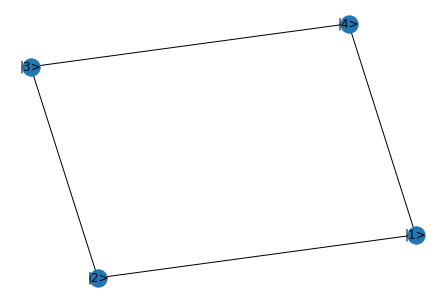

In [35]:
#plot the graph for fun
nx.draw(G, with_labels=True)

In [44]:
f=sq.Ket("f")
g=sq.Ket("g")
h=sq.TensorProduct(a,b)
l=sq.TensorProduct(b,a)
sq.qapply(sq.Dagger(h)*l).doit()

0

### Playing with networks

In [197]:
G = nx.Graph()
G.add_node(1)

In [201]:
G = nx.Graph()
G.add_nodes_from([1,2,3,4,5])
G.add_edges_from([[1,2],[2,3],[3,4],[4,5],[5,1]])

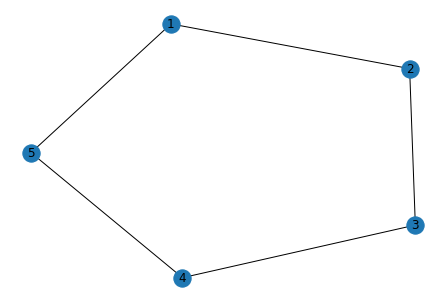

In [205]:
%matplotlib inline 
nx.draw(G, with_labels=True)

In [212]:
3 in G[1]

False

# Ideal KCBS calculations

## Working Version

In [850]:
class cls_iKCBS:    
    
    def __init__(s,n):
        cls_iKCBS.n=n
        #j in 0,1,2,3,4
        s.ke = [bKet(j) for j in range(3)]    
        s.br = [sq.Dagger(s.ke[j]) for j in range(3)]
        s.Πs = []
        
        #evaluate the projectors for the ideal case
        for j in range(n):
            s.Πs.append(s.eval(j,n))
        
        #calculate the matrix representation
        s.matΠs = [sq.represent(_) for _ in s.Πs]
        
        #the first two vectors are taken to be k'
        s.kp = [s.eval(0,n,True),s.eval(1,n,True)]
        
        #the third is constructed as k0 x k1 (cross product) and then added to the list
        s.kp.append(s.cross(s.kp))
        
        #evaluates the conjugate for each element in the list
        s.bp=[sq.Dagger(ikp) for ikp in s.kp]                
        
        #the T prime operator
        s.T = s.kp[0]*s.bp[2] + s.kp[1]*s.bp[0] + s.kp[2]*s.bp[1] 
        s.matT=sq.represent(s.T)
        
        #Now the abstract ones
        
        #creates n abstract projectors (basically just a bunch of non-commuting symbols)
        s._Πs = sp.symbols('Π_0:%d'%n,commutative=False)
        
        #the following will find _Τ as a function of _Πs 
        s._T=s.eval_c() #NB: it computes the coefficients into s.c
        
        #Just trying
        s.U=sq.TensorProduct(s._T,s.Πs[0])
    
    def cross(s,vecs):
        ca=[sq.qapply(sq.Dagger(s.ke[i])*vecs[0]).doit() for i in range(3)]
        cb=[sq.qapply(sq.Dagger(s.ke[i])*vecs[1]).doit() for i in range(3)]
        
        res = (ca[2-1]*cb[3-1] - ca[3-1]*cb[2-1])*s.ke[0] + \
             (ca[3-1]*cb[1-1]-ca[1-1]*cb[3-1])*s.ke[1] + \
             (ca[1-1]*cb[2-1] - ca[2-1]*cb[1-1])*s.ke[2]
        
        return res

    #evaluates the matrices and vectors
    def eval(s,j,n,ve=False):
        N=sp.Integer(n)
        J=sp.Integer(j)
        #print(N,j)
        one=sp.Integer(1)
        #print(one)
        α1=sp.cos((sp.pi)/N)/(one+sp.cos(sp.pi/N)) #verified
        #a1=sp.cos(sp.pi/N)
        #
        #print(α1)
        
        α2=one-α1 #verified
        α3=J * sp.pi * (N-one)/N #verified
        
        vec = sp.sqrt(α1)*s.ke[0] + sp.sqrt(α2)*sp.sin(α3)*s.ke[1] + sp.sqrt(α2)*sp.cos(α3)*s.ke[2]
        
        projector = vec*sq.Dagger(vec)
           
        #matrixprojector = sp.Matrix([0,0])
        #return projector
        
        if ve==False:
            return projector
        else:
            return vec

    
    def eval_c(s,varCount=None):
        cls=s.__class__
        if varCount==None:
            varCount=cls_iKCBS.n*2
        if varCount <= cls.n:
            raise ValueError("number of variables should be at least n")
    
        a=sp.symbols('a0:%d'%varCount)
        #s.b=sp.symbols('b0:%d'%varCount)
        b=[] #family of solutions
        s.c=[] #particular solution with the free variables set to one
        
        #Setting up of constraints
        #If the system is not able to find a solution, consider increasing
        #the number of variables by taking different sets of products or products of three operators
        TfΠ=a[0]*s.Πs[0]
        _TfΠ=a[0]*s._Πs[0]
        for i in range(1,cls.n):
            TfΠ=TfΠ + a[i]*s.Πs[i]
            _TfΠ=_TfΠ + a[i]*s._Πs[i]
        for i in range(cls.n,varCount):
            TfΠ=TfΠ + a[i]*s.Πs[i%cls.n]*s.Πs[(i+2)%cls.n]
            _TfΠ=_TfΠ + a[i]*s._Πs[i%cls.n]*s._Πs[(i+2)%cls.n]
            
            
        LHS=sq.represent(TfΠ)
        
        # LHS=a[0]*s.matΠs[0]
        # for i in range(1,cls.n):
        #     LHS=LHS+a[i]*s.matΠs[i]
        # for i in range(cls.n,varCount):
        #     LHS=LHS+a[i]*s.matΠs[i%cls.n]*s.matΠs[(i+2)%cls.n]
            
        RHS=s.matT
        
        soln=sp.solve(sp.N(LHS-RHS),a,dict=True)

        '''
            #soln=sp.solve([a[0]-1,a[1]-2,a[2]-3,a[3]-4,a[4]-5,a[5]-1,a[6]-1,a[7]-1,a[8]-1,a[9]-1],a,dict=True)

            # sols = solve([t1 + t2 + t3, eq1, eq2], [t1, t2, t3], dict=True)
            # sols[0][t1] # This is t1 in the first solution        
        '''

        #Dictionary to assign one/zero to free variables
        dRem={}
        
        #IMPORTANT: 
        #In sympy, symbols/expressions are unmutable (you can't change them ever);
        #You can save a substituted expression into a new expression (and use a symbol to denote it)
        #To wit: when you substitute, a new expression is produced

        for i in range(varCount):
            #the variables which were evaluated to an expression, assign them to b[i]
            try:
                b.append(soln[0][a[i]])      
            #if the variable was free, assign b[i] to be one
            #and create a dictionary to substitute these free variables
            except:
                b.append(sp.Integer(1))
                dRem[a[i]]=1
        
        #in the solution saved into b[i], substitute for the free variables using the dictionary
        #save the result into the variable c
        s.c = [_.subs(dRem) for _ in b]

        #substitute the solution into the coefficients in Tfπ_p, the operator T as a sum of projectors (and its products)
        dFin={}
        for i in range(varCount):
            dFin[a[i]]=s.c[i]                
        
        return _TfΠ.subs(dFin)
    
    
    #This doesn't work as expected
    def partial_trace(s,M):
        
        s.br_ = [ sq.TensorProduct(sq.IdentityOperator(),_) for _ in s.br]
        s.ke_ = [ sq.TensorProduct(sq.IdentityOperator(),_) for _ in s.ke]
        
        res=0*s.br_[0]*M*s.ke_[0]        #to get the type right!
        for i in range(3):
            for j in range(3):
                res=res+s.br_[i]*M*s.ke_[j]
        return sq.qapply(res).doit()
        

In [851]:

iKCBS=cls_iKCBS(5)

#sp.init_printing()
#sp.pprint(iKCBS.c[0])
for i in range(10):
    display(iKCBS.c[i])
    

display(sp.N(iKCBS.matΠs[1]*iKCBS.matΠs[3]))
display(sp.N(sq.represent(iKCBS.T)))
display(iKCBS._T)


-281239505674985.

-173815573486359.

173815573486360.

281239505674985.

0.956032585889505

281239505674984.

-281239505674983.

-455055079161345.

1

455055079161341.

⎡0.276393202250021   0.292250229469488   0.0949578557832232 ⎤
⎢                                                           ⎥
⎢ 0.1806205750321    0.190983005625053   0.0620541401733395 ⎥
⎢                                                           ⎥
⎣-0.248602893939289  -0.262865556059567  -0.0854101966249685⎦

⎡0.0126398019966776  0.459505841094722  0.888084803048288 ⎤
⎢                                                         ⎥
⎢0.893751184477034   0.393075688878712  -0.216102575316504⎥
⎢                                                         ⎥
⎣-0.448384941374467  0.796458338403433  -0.405715490875389⎦

-281239505674985.0⋅Π₀ + 281239505674984.0⋅Π₀⋅Π₂ - 173815573486359.0⋅Π₁ - 28123
9505674983.0⋅Π₁⋅Π₃ + 173815573486360.0⋅Π₂ - 455055079161345.0⋅Π₂⋅Π₄ + 28123950
5674985.0⋅Π₃ + Π₃⋅Π₀ + 0.956032585889505⋅Π₄ + 455055079161341.0⋅Π₄⋅Π₁

In [852]:
display(iKCBS.U)

#print(iKCBS.partial_trace(iKCBS.U))



                                                                              
                                                                              
                                                                              
                                                                              
(-281239505674985.0⋅Π₀ + 281239505674984.0⋅Π₀⋅Π₂ - 173815573486359.0⋅Π₁ - 2812
                                                                              
                                                                              
                                                                              
                                                                              

                                                                              
                                                                              
                                                                              
                                                   

In [37]:
Identity=sq.IdentityOperator()
g=bKet(0)
h=bKet(1)

ρ_g=g*sq.Dagger(g)
ρ_h=h*sq.Dagger(h)

#sq.qapply(Identity*g); seems to work

#display(sq.TensorProduct(ρ_g,ρ_h))
print("g")
g_=sq.TensorProduct(Identity,g*sq.Dagger(g)); display(g_)
print("h")
h_=sq.TensorProduct(Identity,h*sq.Dagger(h)); display(h_)

print("gh")
display(sq.Dagger(g_)*h_)


sq.qapply(sq.Dagger(g_)*h_).doit() #*ρ_g

#sq.qapply(sq.Dagger(g)*h).doit()

g


I⨂ ❘0⟩⟨0❘

h


I⨂ ❘1⟩⟨1❘

gh


I⨂ ❘0⟩⟨0❘⋅I⨂ ❘1⟩⟨1❘

I⨂ (❘0⟩⋅⟨0❘⋅❘1⟩⟨1❘)

### Debugging the issue with substitutions

In [758]:

iKCBS.b[1].subs({iKCBS.a[8]:0})

iKCBS.c
#b=sp.symbols('b0:%d'%10)
#b[0].subs(b[0],10)
# gla=sp.Symbol('x'); gla
# gla.subs(gla,10)

#iKCBS.a[8].subs(iKCBS.a[8],0)

[-281239505674985.,
 -173815573486359.,
 173815573486360.,
 281239505674985.,
 0.956032585889505,
 281239505674984.,
 -281239505674983.,
 -455055079161345.,
 1,
 455055079161341.]

In [550]:
ket1=bKet(0)
ket2=bKet(1)
kets=(ket1,ket2)
bra=[sq.Dagger(iket) for iket in kets]; bra

[<0|, <1|]

### Debugging the issue with _eval_args

In [359]:
class cls_iKCBS:    
    
    def __init__(s,n):
        cls_iKCBS.n=n
        #j in 0,1,2,3,4
        s.ke = [bKet(j) for j in range(3)]    
        s.br = [sq.Dagger(s.ke[j]) for j in range(3)]
        s.πs = []
        s.matπs = [] 
        #poor man's implementation
        for j in range(5):
            s.πs.append(s.proj(j,n))            
            s.matπs.append(s.matRep(s.proj(j,n)))
        s.opT = s.ke[0]*s.br[2] + s.ke[1]*s.br[0] + s.ke[2]*s.br[1]
        s.matT=s.matRep(s.opT)

    #this method is now obsolete    
    def matRep(s,op):
        n=3 #s.__class__.n
        matop = sp.Matrix(np.zeros((n,n)))        
        for i in range(n):
            for j in range(n):
                matop[i,j] = sq.qapply(sq.Dagger(s.ke[i])*op*s.ke[j]).doit() 
        return matop
        
    def proj(s,j,n):
        N=sp.Integer(n)
        J=sp.Integer(j)
        #print(N,j)
        one=sp.Integer(1)
        #print(one)
        α1=sp.cos((sp.pi)/N)/(one+sp.cos(sp.pi/N)) #verified
        #a1=sp.cos(sp.pi/N)
        #
        #print(α1)
        
        α2=one-α1 #verified
        α3=J * sp.pi * (N-one)/N #verified
        
        vec = sp.sqrt(α1)*s.ke[0] + sp.sqrt(α2)*sp.sin(α3)*s.ke[1] + sp.sqrt(α2)*sp.cos(α3)*s.ke[2]
        
        projector = vec*sq.Dagger(vec)
           
        #matrixprojector = sp.Matrix([0,0])
        return projector
    
    
    def find_coeff_matT(s):
        cls=s.__class__
        a=sp.symbols('a0:%d'%(cls.n*2))
        LHS=a[0]*s.matπs[0]
        for i in range(1,cls.n):
            LHS=LHS+a[i]*s.matπs[i]
        for i in range(cls.n,2*cls.n):
            LHS=LHS+a[i]*s.matπs[i%cls.n]*s.matπs[(i+2)%cls.n]
            
        RHS=s.matT
        return sp.solve(sp.N(LHS-RHS),a)
        #return sp.solve(a[0]-a[2],a)
        
        #print(LHS)
        #for i in range
        

    '''
       def vec(self,j,n):    
           N=sp.Integer(n)
           J=sp.Integer(j)
           #print(N,j)
           one=sp.Integer(1)
           #print(one)
           α1=sp.cos((sp.pi)/N)/(one+sp.cos(sp.pi/N)) #verified
           #a1=sp.cos(sp.pi/N)
           #
           #print(α1)
        
           α2=one-α1 #verified
           α3=J * sp.pi * (N-one)/N #verified
        
           vec = sp.sqrt(α1)*self.k0 + sp.sqrt(α2)*sp.sin(α3)*self.k1 + sp.sqrt(α2)*sp.cos(α3)*self.k2
        
           #projector = vec*sq.Dagger(vec)
           return vec
    '''

In [360]:

iKCBS=cls_iKCBS(5)
#to access the vectors 

# #uncomment to test
# sq.qapply(sq.qapply(iKCBS.πs[0]*iKCBS.πs[1]))
# #iKCBS.πs[1]

# sp.N(iKCBS.matπs[2])

# iKCBS.find_coeff_matT()

eval args
eval args
eval args
(1/4 + sqrt(5)/4)/(sqrt(5)/4 + 5/4) -(1/4 + sqrt(5)/4)/(sqrt(5)/4 + 5/4) + 1 0
[|0>, |1>, |2>]
sqrt(1/4 + sqrt(5)/4)*|0>/sqrt(sqrt(5)/4 + 5/4) + sqrt(-(1/4 + sqrt(5)/4)/(sqrt(5)/4 + 5/4) + 1)*|2>
(1/4 + sqrt(5)/4)/(sqrt(5)/4 + 5/4) -(1/4 + sqrt(5)/4)/(sqrt(5)/4 + 5/4) + 1 0
[|0>, |1>, |2>]
sqrt(1/4 + sqrt(5)/4)*|0>/sqrt(sqrt(5)/4 + 5/4) + sqrt(-(1/4 + sqrt(5)/4)/(sqrt(5)/4 + 5/4) + 1)*|2>


In [26]:
iKCBS.find_coeff_opT()

a0*(sqrt(1/4 + sqrt(5)/4)*|0>/sqrt(sqrt(5)/4 + 5/4) + sqrt(-(1/4 + sqrt(5)/4)/(sqrt(5)/4 + 5/4) + 1)*|2>)*(sqrt(1/4 + sqrt(5)/4)*<0|/sqrt(sqrt(5)/4 + 5/4) + sqrt(-(1/4 + sqrt(5)/4)/(sqrt(5)/4 + 5/4) + 1)*<2|) + a1*(sqrt(1/4 + sqrt(5)/4)*|0>/sqrt(sqrt(5)/4 + 5/4) + sqrt(5/8 - sqrt(5)/8)*sqrt(-(1/4 + sqrt(5)/4)/(sqrt(5)/4 + 5/4) + 1)*|1> + (-sqrt(5)/4 - 1/4)*sqrt(-(1/4 + sqrt(5)/4)/(sqrt(5)/4 + 5/4) + 1)*|2>)*(sqrt(1/4 + sqrt(5)/4)*<0|/sqrt(sqrt(5)/4 + 5/4) + sqrt(5/8 - sqrt(5)/8)*sqrt(-(1/4 + sqrt(5)/4)/(sqrt(5)/4 + 5/4) + 1)*<1| + (-sqrt(5)/4 - 1/4)*sqrt(-(1/4 + sqrt(5)/4)/(sqrt(5)/4 + 5/4) + 1)*<2|) + a2*(sqrt(1/4 + sqrt(5)/4)*|0>/sqrt(sqrt(5)/4 + 5/4) - sqrt(sqrt(5)/8 + 5/8)*sqrt(-(1/4 + sqrt(5)/4)/(sqrt(5)/4 + 5/4) + 1)*|1> + (-1/4 + sqrt(5)/4)*sqrt(-(1/4 + sqrt(5)/4)/(sqrt(5)/4 + 5/4) + 1)*|2>)*(sqrt(1/4 + sqrt(5)/4)*<0|/sqrt(sqrt(5)/4 + 5/4) - sqrt(sqrt(5)/8 + 5/8)*sqrt(-(1/4 + sqrt(5)/4)/(sqrt(5)/4 + 5/4) + 1)*<1| + (-1/4 + sqrt(5)/4)*sqrt(-(1/4 + sqrt(5)/4)/(sqrt(5)/4 + 5/4) + 1

### Debugging

In [242]:
sq.qapply(sq.Dagger(iKCBS.πs[0])*iKCBS.πs[1]);

#sq.represent(sq.qapply(sq.Dagger(iKCBS.πs[0])*iKCBS.πs[1]),basis=iKCBS.ke)

In [192]:
#older version without lists
class cls_iKCBS:
    k0=bKet(0)    
    k1=bKet(1)
    k2=bKet(2)
    
    b0=sq.Dagger(k0)
    b1=sq.Dagger(k1)
    b2=sq.Dagger(k2)
    
    πs=[]
    
    def __init__(self,n):
        #j in 0,1,2,3,4
        for j in range(5):
            self.πs.append(self.proj(j,n))
    
    def proj(self,j,n):
        N=sp.Integer(n)
        J=sp.Integer(j)
        #print(N,j)
        one=sp.Integer(1)
        #print(one)
        α1=sp.cos((sp.pi)/N)/(one+sp.cos(sp.pi/N)) #verified
        #a1=sp.cos(sp.pi/N)
        #
        #print(α1)
        
        α2=one-α1 #verified
        α3=J * sp.pi * (N-one)/N #verified
        
        vec = sp.sqrt(α1)*self.k0 + sp.sqrt(α2)*sp.sin(α3)*self.k1 + sp.sqrt(α2)*sp.cos(α3)*self.k2
        
        projector = vec*sq.Dagger(vec)
        return projector
    '''
       def vec(self,j,n):    
           N=sp.Integer(n)
           J=sp.Integer(j)
           #print(N,j)
           one=sp.Integer(1)
           #print(one)
           α1=sp.cos((sp.pi)/N)/(one+sp.cos(sp.pi/N)) #verified
           #a1=sp.cos(sp.pi/N)
           #
           #print(α1)
        
           α2=one-α1 #verified
           α3=J * sp.pi * (N-one)/N #verified
        
           vec = sp.sqrt(α1)*self.k0 + sp.sqrt(α2)*sp.sin(α3)*self.k1 + sp.sqrt(α2)*sp.cos(α3)*self.k2
        
           #projector = vec*sq.Dagger(vec)
           return vec
    '''

In [137]:
iKCBS=cls_iKCBS()
sq.qapply(iKCBS.proj(1,5)).doit();

In [154]:
sp.simplify(sq.qapply(sq.Dagger(iKCBS.k0)*iKCBS.proj(1,5)*iKCBS.proj(2,5)*iKCBS.k0).doit())
#sp.N(sq.qapply(sq.Dagger(iKCBS.k0)*iKCBS.proj(1,5)*iKCBS.proj(2,5)*iKCBS.k0).doit())
#sq.qapply(iKCBS.proj(1,5)*iKCBS.proj(2,5)).doit()

(-7*sqrt(25 - 5*sqrt(5))/8 - 15*sqrt(5 - sqrt(5))/8 + sqrt(5*sqrt(5) + 25)/2 + 5*sqrt(sqrt(5) + 5)/4)/(sqrt(sqrt(5) + 5)*(2*sqrt(5) + 5))

In [129]:
(sq.Dagger(iKCBS.k0)*iKCBS.k0).doit()

1

In [145]:
sp.N(sq.qapply(sq.Dagger(iKCBS.vec(1,5))*iKCBS.vec(1,5)).doit(),5000)

1.00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

In [158]:
sp.N(sp.simplify(sq.qapply(sq.Dagger(iKCBS.vec(4,5))*iKCBS.vec(3,5)).doit()))

-0.e-140

In [176]:
sp.N(sq.qapply(sq.Dagger(iKCBS.πs[0])*iKCBS.πs[1]))

-2.77555756156289e-17*|2><0| - 9.71445146547012e-17*|2><1| + 5.55111512312578e-17*|2><2|

## Translation Operator using $\Pi$s

See for the original implementation Self-testing_KCBS_fidelity_bounds

In [12]:

a=sp.symbols('a0:%d'%(cls_iKCBS.n*2))
a[0]
c=0
c=c+a[0]; c


a0

In [174]:
a=sp.Matrix(np.zeros((2,2)))
a[1,1]=0;a


Matrix([
[0.0, 0.0],
[0.0,   0]])

In [231]:
a=sqq.IntQubit(2);a

b=sqq.IntQubit(1);
sq.represent(b);
sq.represent(a)

Matrix([
[0],
[0],
[1],
[0]])

# SDP part (SymPy meets CvxPy)

In [135]:
N=5

#Ψ=[sp.symbols('Ψ')]
I=[sp.Integer(1)]
A=list(sp.symbols('A_0:%d'%N,commutative=False))
# display(I)
# display(A)

In [136]:
objective = A[0] + A[1] 

display(objective);

A₀ + A₁

In [137]:


L1=A #appends the lists
#print(L1)

L2=[]
for let1 in L1:
    for let2 in L1:
        L2.append(let1*let2)


#These will help simplify A^3 to A when needed
lDepth=2
sqDicts={A[i]**2:A[i] for i in range(len(L1))}


L = I + L1 + L2
L_ = L1 + L2
#print(L)

In [138]:
#symbol to index dictionary
sTi={}

for i in range(len(L)):
    sTi[L[i]]=i

#print(sTi)

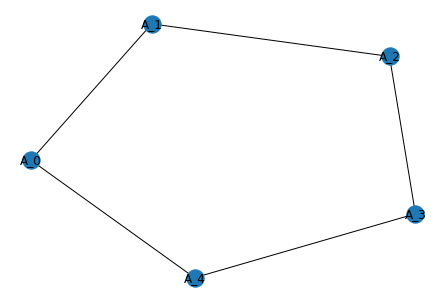

In [139]:
G = nx.Graph()

#node2 in G[node1] #yes if they are connected by an edge

G = nx.Graph()
G.add_nodes_from(L1)
G.add_edges_from([[L1[i],L1[(i+1)%(N)]] for i in range(N)])

%matplotlib inline 
nx.draw(G, with_labels=True)

### Zero list (useless?)

In [23]:
zeroDict={}
zeroList=[]
for _ in L1:
    for _2 in L1:
        if _ in G[_2]: #share an edge
            zeroDict[_*_2]=0
            zeroList.append(_*_2)

#print(zeroDict);

### Creating the matrix of symbols (just for show; useless)

In [15]:
#creating the matrix

matList=[]

for _ in L:
    matList.append([_*_2 for _2 in L])

#print(matList)

sp.Matrix(matList);

### Sympy says hello to Cvxpy

In [148]:
#L is the alphabet, to wit: it is the list of letters
#
X = cp.Variable((len(L),len(L)),symmetric=True)

lI = I[0]

#>> is for matrix inequality
constraints = [X >> 0,X[sTi[lI],sTi[lI]]==1]

#objective
#y = objective.subs({A[0]:X[sTi[A[0]]],A[1]:X[sTi[A[1]]]})
#y = objective.subs({A[0]:sTi[A[0]],A[1]:sTi[A[1]]})


# objective function evaluated (loop over product of all letters)
y = 0

termsUsed = []
for l1 in L:
    for l2 in L:
        if l1 != lI or l2 != lI: #this is because if we ask for the coefficient of 1, things get messed up
            term = l1*l2
            
            #the same term can be represented by many elements in the matrix
            #we satisfy ourselves with picking just one of them
            if not(term in termsUsed):
                termsUsed.append(term)                
                eX = X[sTi[l1]][sTi[l2]] #picks the corresponding element from the variable matrix of the SDP library
                #print(coeff)
                #print(l1,l2)
                coeff = sp.N(objective.coeff(l1*l2)) #evaluates the coff of l1*l2 in the objective
                y += coeff*eX

#Constraints from the graph (these come from single letters)        
for l1 in L1:
    for l2 in L1:
        eX = X[sTi[l1]][sTi[l2]] #picks the corresponding element from the variable matrix of the SDP library
        if l1 in G[l2]:
            constraints += [eX == 0]
        
        #print(coeff,sTi[l1])
        #display(l1)

#constraints from the fact that Π^2=Π
# for l in L1:
#     constraints += [ X[sTi[lI]][sTi[l]] == X[sTi[l]][sTi[l]] ]
#     #constraints to match with experiment

dictTerms = {}
#lettersUsed = []
for l1 in L:
    for l2 in L:
        term = l1*l2

        del tS
        tS=[term]
        #display(term)
        for i in range(lDepth+1):
            tS.append(tS[-1].subs(sqDicts))
        simTerm=tS[-1]
        #display(simTerm)

        if not(simTerm in dictTerms):
            dictTerms.update({simTerm:[l1,l2]})            
        else:
            l1_=dictTerms[simTerm][0]
            l2_=dictTerms[simTerm][1]
            #print(l1_,l2_)            
            #print(sTi[l1_],sTi[l2_])
            
            #print(l1,l2)            
            #print(sTi[l1],sTi[l2])
            
            #constraints += [ X[sTi[l1]][sTi[l2]] == X[sTi[l1_]][sTi[l2_]] ] 
            # print(X[sTi[l1]][sTi[l2]])
            # print(X[sTi[l1_]][sTi[l2_]])
            constraints += [ X[sTi[l1]][sTi[l2]] == X[sTi[l1_]][sTi[l2_]] ]

# display(y)

# display(objective.args[0])
# display(objective.args[1])

#prob = cp.Problem(cp.Maximize(y),constraints)
#prob.solve()

#expr=A[0]*A[0]*A[0]*A[1]*A[0]*A[1]

    



#display(tS[-1])


# powDicts={}
# for i in range(len(L1)):
#     powDicts.update({A[i]**k:A[i] for k in range(2,lDepth+4)[::-1]})


#expr.subs(powDicts)

# display(expr.subs(sqDicts))
# display(expr.subs(powDicts).subs(powDicts))

#expr
    
#dict={A[i]**k:A[i] for k in range(lDepth)}

#print(powDicts)

#result=expr.subs({A[0]*A[0]:A[1]}); result
#result=sp.refine(expr,)

## Inputs